# 0. Import packages

In [27]:
%pip install plotly
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from pandas.plotting import table
from pandas.io.json import json_normalize
from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
plt.style.use('fivethirtyeight')


Note: you may need to restart the kernel to use updated packages.


# 1. Get data from Coinmarketcap

## 1.1 From CMC API
Copy youe cmc api key to retrive the data.

In [1]:
# Set Params
num_tokens = str(1000)
api_key = ''

In [3]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest?aux=cmc_rank,date_added'
parameters = {
  'start':'1',
  'limit':num_tokens,
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': api_key,
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)

{'status': {'timestamp': '2022-12-21T13:53:52.308Z', 'error_code': 0, 'error_message': None, 'elapsed': 302, 'credit_count': 5, 'notice': None, 'total_count': 8981}, 'data': [{'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'slug': 'bitcoin', 'date_added': '2013-04-28T00:00:00.000Z', 'cmc_rank': 1, 'self_reported_circulating_supply': None, 'self_reported_market_cap': None, 'tvl_ratio': None, 'last_updated': '2022-12-21T13:52:00.000Z', 'quote': {'USD': {'price': 16844.031184663087, 'volume_24h': 17495892270.722614, 'volume_change_24h': -21.9458, 'percent_change_1h': -0.17866782, 'percent_change_24h': 0.15286317, 'percent_change_7d': -5.8037837, 'percent_change_30d': 4.2107163, 'percent_change_60d': -12.28851063, 'percent_change_90d': -11.43939203, 'market_cap': 324073567774.56445, 'market_cap_dominance': 39.9638, 'fully_diluted_market_cap': 353724654877.92, 'tvl': None, 'last_updated': '2022-12-21T13:52:00.000Z'}}}, {'id': 1027, 'name': 'Ethereum', 'symbol': 'ETH', 'slug': 'ethereum', 'dat

In [4]:
# Transform json to pandas dataframe
df = json_normalize(data['data'])

/var/folders/x7/dln2v9vs69gdf84nt96l91b40000gn/T/ipykernel_5778/2369792260.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(data['data'])


## 1.2 (Alternative) Read csv from local
Get data from cmc through api connector and save data as csv

# 2. Preprocessing

In [5]:
# Rename columns and convert data_added from date-time to date
col_name ={}
for i in df.columns:
    new = i.split('.')[-1:][0]
    col_name[i] = new
df.rename(columns=col_name, inplace=True)
df['date_added_n'] = pd.to_datetime(df['date_added'].str[:10], format='%Y-%m-%d')
df = df.sort_values('market_cap', ascending=False)

# 3. Top coins and its market share
Use the function below to see BTC and other coins market share

In [17]:
def market_cap_perc(topn, outofn=-1):    
    """
    :param:
    topn: int, >0 and  <= 100, the number of top coins want to check
    outofn: int > 0 and <= 100, the first N coins be considered in total market share; default value set to all coins 
    """
    # Error handling
    if topn > 100 or outofn >100 or topn <1 or outofn < -1 or outofn == 0:
        return 'This dataset contains only top 100 currencies, please try a number from 1 to 100'
    
    TOP_CAP_TITLE = 'Top '+str(topn)+' Market Capitalization'

    # Selecting the first N cryptos
    df10 = df.head(topn).set_index('symbol')
    
    if outofn == -1:
        TOP_CAP_YLABEL = '% of Total Cap'
        ax = df10['market_cap_dominance'].plot.bar(fontsize=10, color='#b56576')
    else:
        TOP_CAP_YLABEL = '% of Top '+str(outofn)+' Total Cap'
        # Calculating market_cap_perc, total market cap include only top 100 cryptos
        df10['market_cap_perc'] = df10['market_cap']*100/df['market_cap'][:outofn].sum()
        ax = df10['market_cap_perc'].plot.bar(fontsize=10, color='#355070')   

    # Annotating
    ax.set_title(TOP_CAP_TITLE,fontsize=15)
    ax.set_ylabel(TOP_CAP_YLABEL, fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), decimals=1)), (p.get_x() * 1.05, p.get_height() * 1.05), fontsize=8)
      
    
    # Tree map
    color_continuous_scale=["#355070","#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b"]
    df10 = df10.reset_index()
    fig = px.treemap(df10, path=[px.Constant('Market Cap'), 'symbol'],
                     values=df10.market_cap,
                     color='symbol',                
                     color_discrete_sequence=color_continuous_scale,
                     hover_name='symbol'
                    )

    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    
    # Show plot
    ax
    fig.show()

## Example

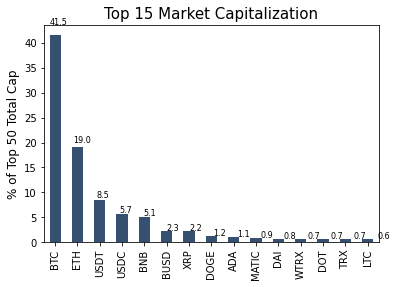

In [23]:
market_cap_perc(15, 50)

# 4. Price changes  %
Use the function to find out the top volitile coin(gainer and both loser)

In [19]:
def price_change(t, topn):
    """
    :param:
    t: str, time interval, options include: '1h', '24h', '7d', '30d', '60d', '90d'
    topn: int, < 0 and >= 100, top N volitile coins to show
    """

    # Check if t is valid
    t = str(t)
    valid_t = ['1h', '24h', '7d', '30d', '60d', '90d']
    if t not in valid_t:
        return 'Time interval not valid, shold be: 1h, 24h, 7d, 30d, 60d, 90d '
    
    # Check topn validity
    if topn < 1 or topn > 100:
        return 'This dataset contains only top 100 currencies, please try a number from 1 to 100'
    
    
    col = 'percent_change_'+t
    dftop = df.sort_values(col, ascending=False).head(topn).set_index('symbol')
    dftail = df.sort_values(col, ascending=False).tail(topn).set_index('symbol')
    
    # Making the subplot and the figure for two side by side plots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    # Plotting with pandas the barchart for the top gainer
    ax = dftop[col].plot.bar(ax=axes[0], color='#b56576',fontsize=10)
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), decimals=1)), (p.get_x() * 1.05, p.get_height() * 1.05), fontsize=8)
    
    # Setting the figure's main title to the text passed as parameter
    fig.suptitle('Top'+str(topn)+' Volitile Coins in '+t, fontsize=15)
    
    # Setting the ylabel to '% change'
    ax.set_ylabel('% change', fontsize=12)
    ax.set_xlabel('')
    
    # Same as above, but for the top loser
    ax = dftail[col].plot.bar(ax=axes[1], color='#355070', fontsize=10)
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), decimals=1)), (p.get_x() * 1.05, p.get_height() * 1.05), fontsize=8)
    
    return fig, ax


## Example

(<Figure size 720x432 with 2 Axes>, <AxesSubplot:xlabel='symbol'>)

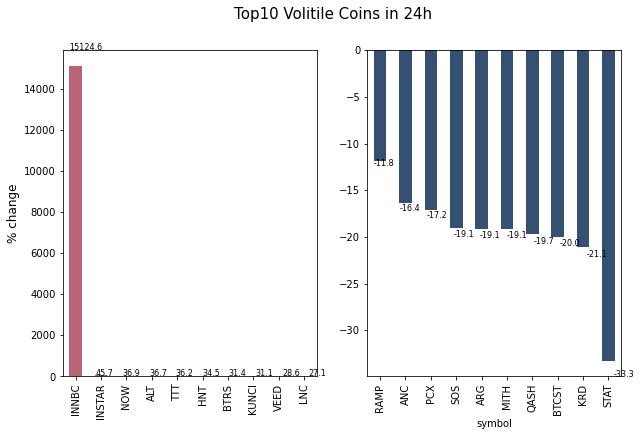

In [22]:
price_change('24h', 10 )

# 5. Newbies
Use the function below to find newly added coins in recent days

In [52]:
def newbies(num_days):
    """
    :param:
    days: int, >=0, the number of recent days that wants to check
    """
    
    # Error handling
    if num_days < 0:
        return 'Number of days should be >= 0.'
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # filter newly added coins within N days
    df2 = df[df['date_added_n'] > datetime.now() - pd.to_timedelta(str(num_days)+"day")]
    
    
    if df2['id'].count() < 1:
        return 'No new coin added in '+str(num_days)+' days.'
    
    df2 = df2.set_index('symbol')
    ax = (df2['market_cap']/1000000).plot.bar(color='#355070')
    ax.set_ylabel('USD(million)',fontsize=12)
    ax.set_xlabel('')
    ax.set_title('Market Cap: Newbies in Recent '+str(num_days)+' Days', fontsize=12)
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), decimals=1)), (p.get_x() * 1.05, p.get_height() * 1.05), fontsize=10)

    pre = df2[['name', 'date_added_n', 'price', 'volume_24h']]
    return ax, pre
    

## Example

(<AxesSubplot:title={'center':'Market Cap: Newbies in Recent 70 Days'}, ylabel='USD(million)'>,
                    name date_added_n  price   volume_24h
 symbol                                                  
 APT               Aptos   2022-10-19  3.771 58739353.328
 TMG           T-mac DAO   2022-11-04  0.248    92275.759
 HOOK    Hooked Protocol   2022-12-01  1.388 15442640.412
 HFT            Hashflow   2022-10-31  0.319 10747344.122
 ACX     Across Protocol   2022-11-09  0.044    56419.637)

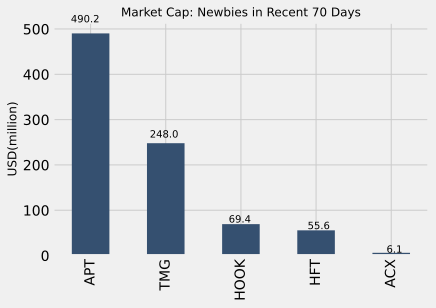

In [53]:
newbies(70)